In [11]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import torch

from sda.mcs import *
from sda.score import *
from sda.utils import *

from experiments.kolmogorov.utils import *

chain = make_chain()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Score network

In [12]:
# score = load_score(PATH / 'runs/glorious-flower-3_zw7vkqm0/state.pth')  # k=1, width=32
# score = load_score(PATH / 'runs/azure-wave-2_9ry6v9ul/state.pth')  # k=1, width=64
# score = load_score(PATH / 'runs/bumbling-monkey-6_3m4uyfe8/state.pth')  # k=1, width=96
# score = load_score(PATH / 'runs/graceful-snowball-8_i6pzpnst/state.pth')  # k=2, width=96
score_path = PATH / 'runs/treasured-durian-3_acsay1ip/state.pth'
score = load_score(score_path)

## Circle

In [13]:
def circle():
    x = torch.linspace(-1, 1, 64)
    x = torch.cartesian_prod(x, x)

    dist = x.square().sum(dim=-1).reshape(64, 64)
    mask = torch.logical_and(0.4 < dist, dist < 0.6)

    return mask

mask = circle().cuda()

def A(x):
    return chain.vorticity(x[..., -1, :, :, :]) * mask

sde = VPSDE(
    GaussianScore(
        y=0.6 * mask,
        A=A,
        std=0.2,
        sde=VPSDE(score, shape=()),
    ),
    shape=(8, 2, 64, 64),
).cuda()

  0%|                                                           | 0/256 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.29it/s]


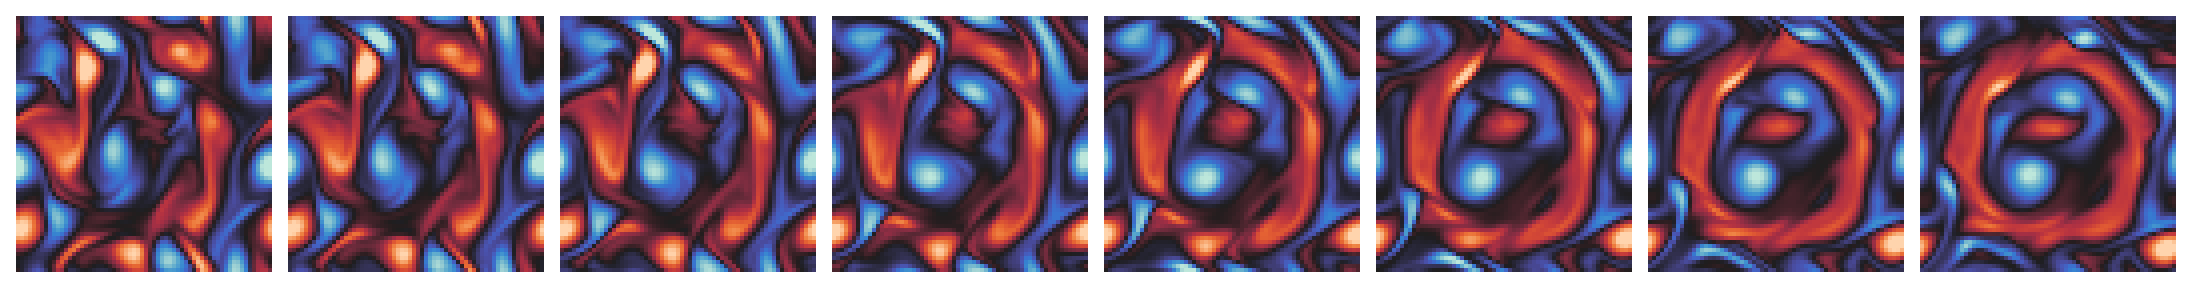

In [14]:
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_circle.png')
draw(w, zoom=4)

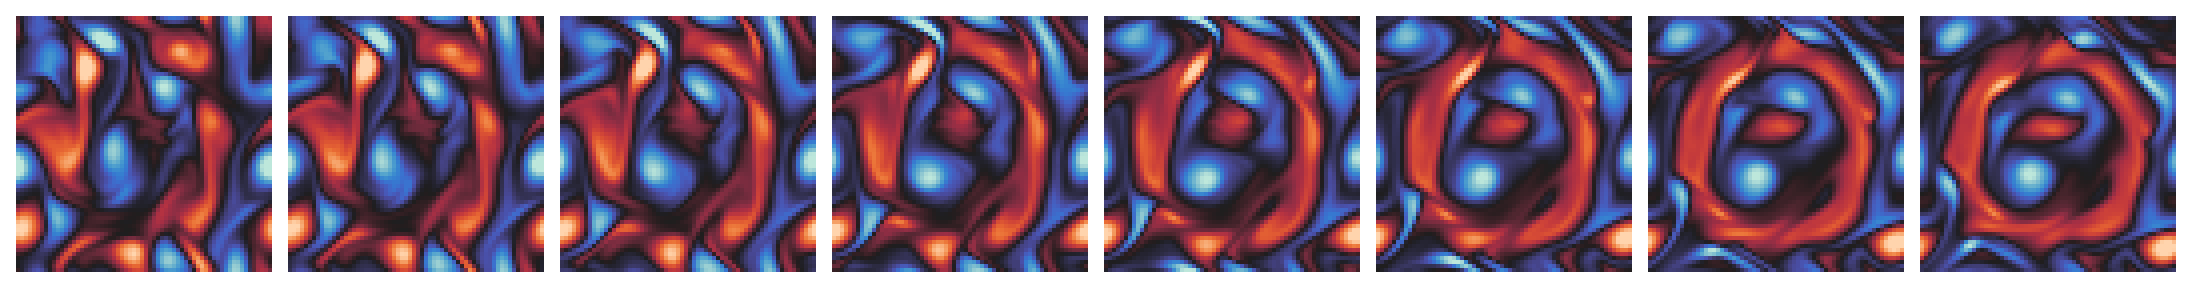

In [15]:
y0 = chain.upsample(x[0], 4)
y = chain.trajectory(y0, length=7)
y = torch.cat((y0[None], y))
y = chain.coarsen(y, 4)

w = chain.vorticity(y)

draw(w, zoom=4).save('x_circle_sim.png')
draw(w, zoom=4)

## Assimilation

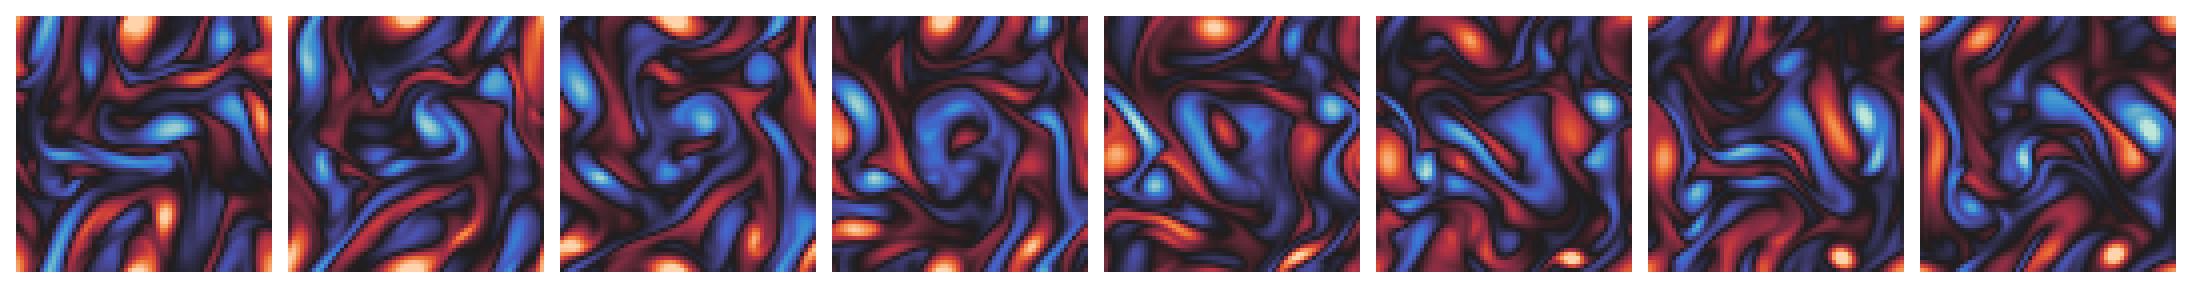

In [16]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][1, :29])

w = chain.vorticity(x_star[::4])

draw(w, zoom=4).save('x_star_assim.png')
draw(w, zoom=4)

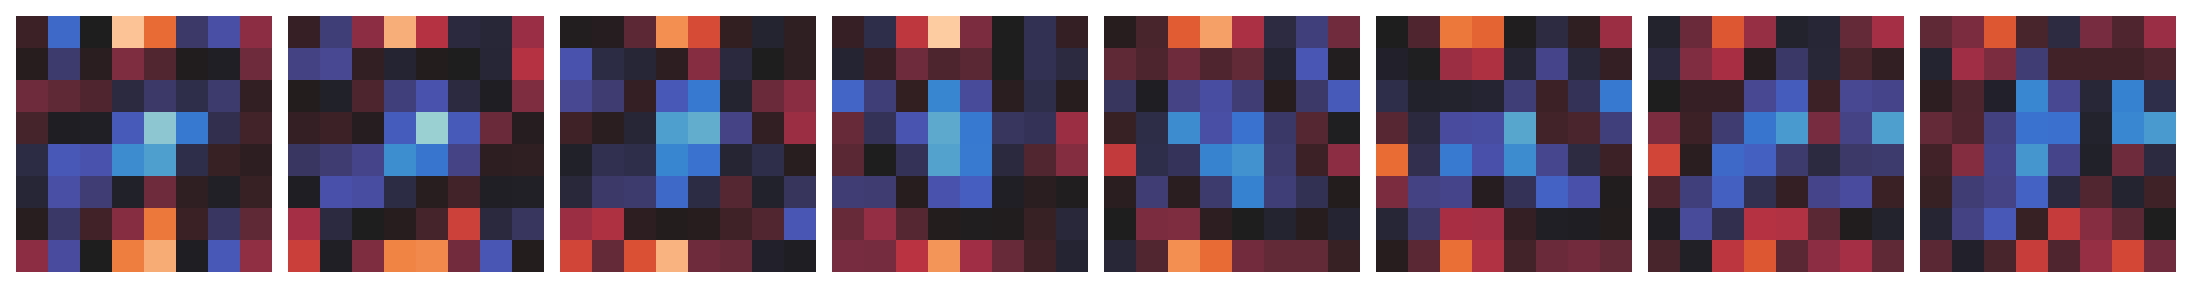

In [17]:
def A(x):
    return chain.coarsen(x[..., ::4, :, :, :], 8)

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(y_star) / 2.5
w = chain.upsample(w, 2, mode='nearest')

draw(w, pad=1, zoom=16).save('y_star_assim.png')
draw(w, pad=1, zoom=16)

  0%|▏                                                  | 1/256 [00:00<03:56,  1.08it/s]

100%|█████████████████████████████████████████████████| 256/256 [04:41<00:00,  1.10s/it]


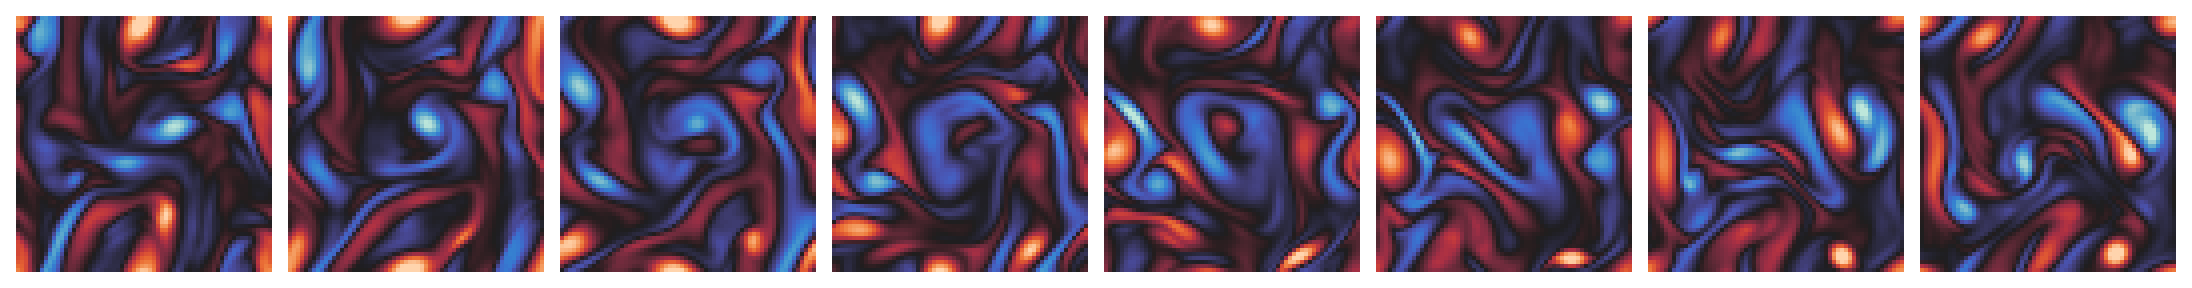

In [18]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::4])

draw(w, zoom=4).save('x_sda_assim.png')
draw(w, zoom=4)

In [19]:
(A(x) - y_star).std()  # should be ≈ 0.1

tensor(0.1096)

  0%|                                                           | 0/256 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████| 256/256 [04:41<00:00,  1.10s/it]


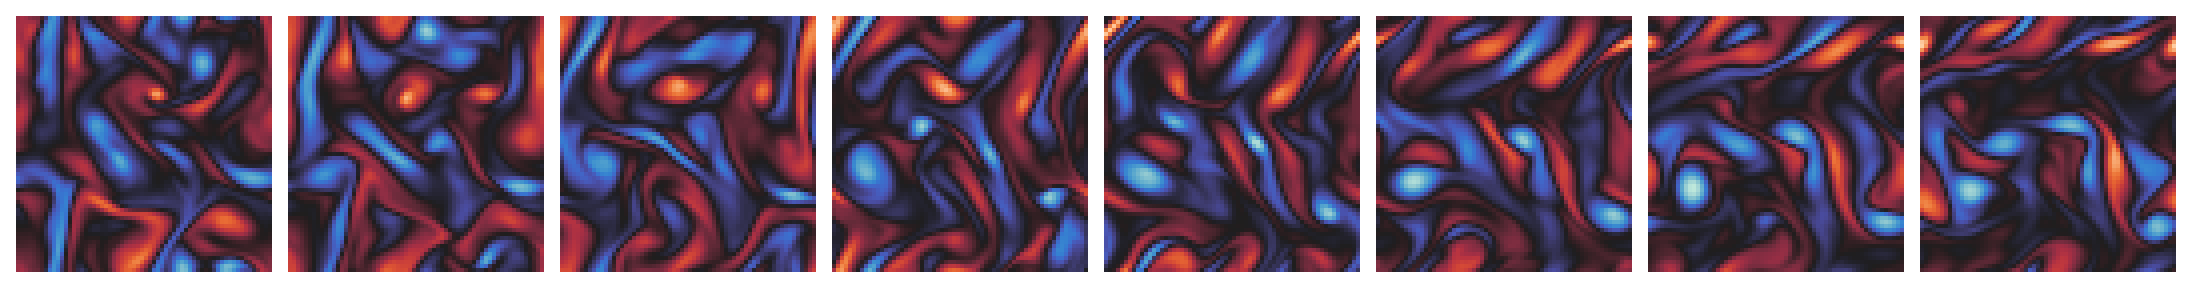

In [ ]:
# sde = VPSDE(
#     DPSGaussianScore(
#         y_star,
#         A=A,
#         zeta=1.0,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=x_star.shape,
# ).cuda()

# x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
# w = chain.vorticity(x[::4])

# draw(w, zoom=4).save('x_dps_assim.png')
# draw(w, zoom=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class WithC(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x, t, c=None):  # c を受け取るが使わない
        return self.base(x, t)

# 既存の構成そのまま
inner = VPSDE(score, shape=()).to(device)
eps = DPSGaussianScore(y_star.to(device), A=A, zeta=1.0, sde=inner).to(device)

# ★ アダプタで 3 引数互換に
eps3 = WithC(eps)

sde = VPSDE(eps3, shape=x_star.shape).to(device)

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::4])

draw(w, zoom=4).save('x_dps_assim.png')
draw(w, zoom=4)

In [23]:
(A(x) - y_star).std()

tensor(0.7161)

## Extrapolation

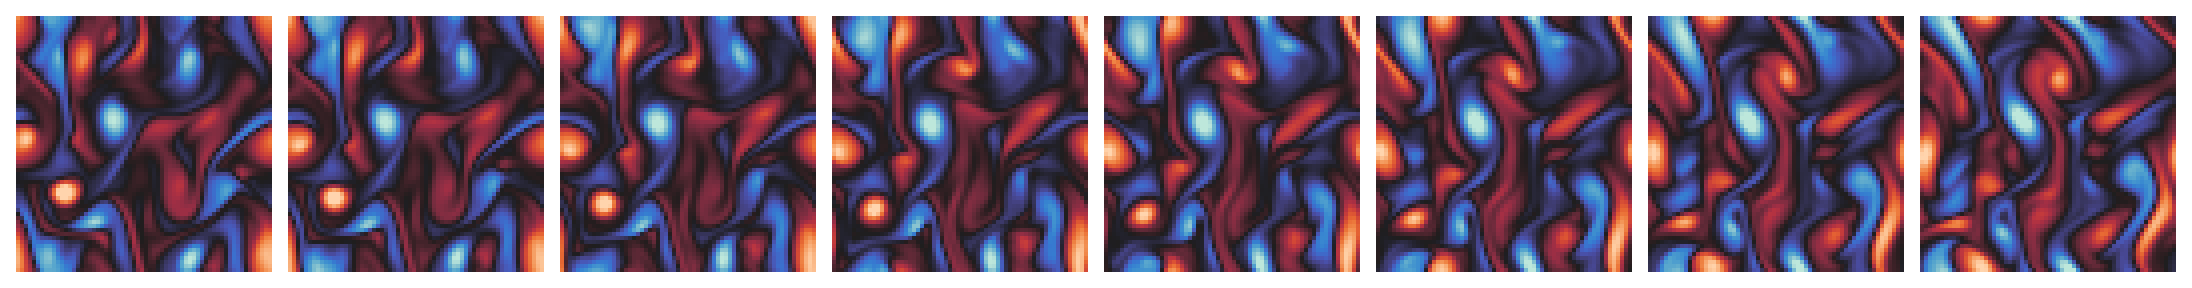

In [24]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][0, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_extra.png')
draw(w, zoom=4)

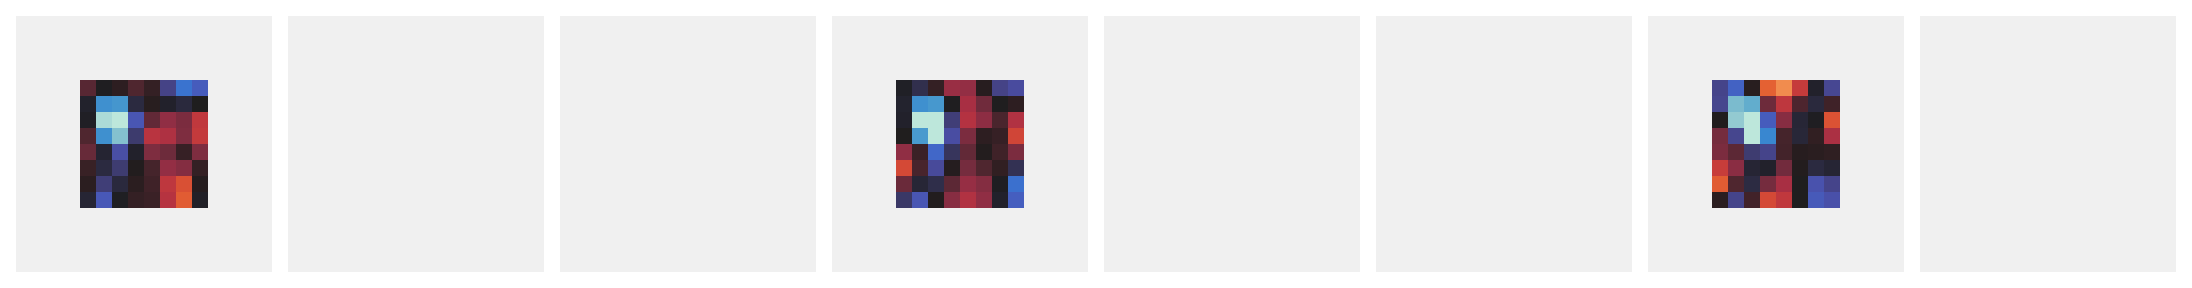

In [25]:
def A(x):
    return chain.coarsen(x, 4)[..., ::3, :, 4:12, 4:12]

y_star = torch.normal(A(x_star), 0.01)

w = chain.vorticity(chain.coarsen(x_star, 4)) / 2

mask = np.zeros((8, 16, 16), dtype=bool)
mask[::3, 4:12, 4:12] = True

draw(w, mask, pad=1, zoom=16).save('y_star_extra.png')
draw(w, mask, pad=1, zoom=16)

  1%|▌                                                  | 3/256 [00:00<00:46,  5.44it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.30it/s]


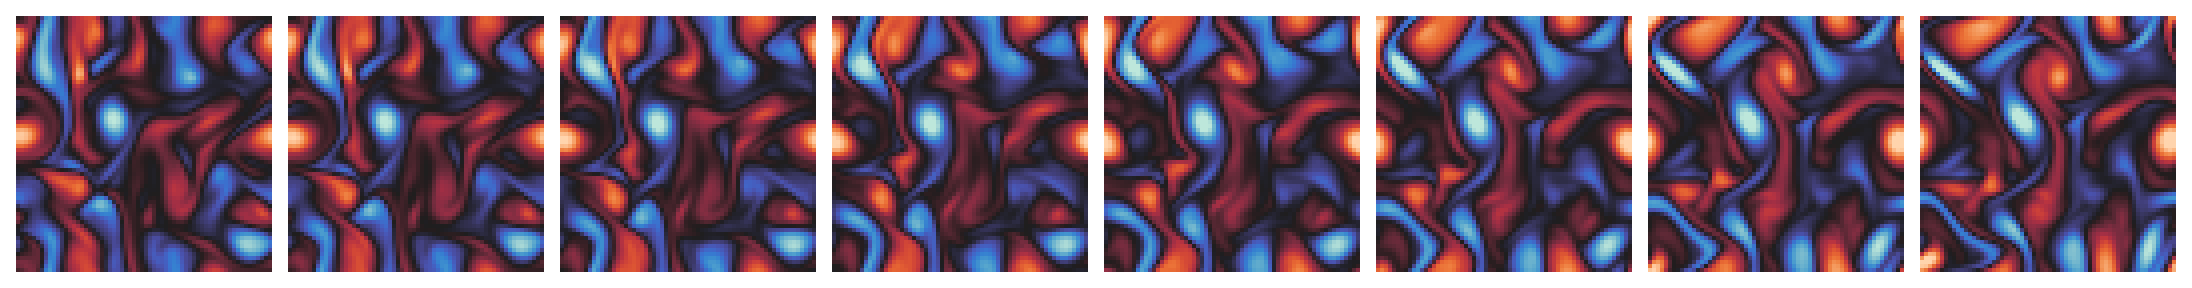

In [26]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.01,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_extra.png')
draw(w, zoom=4)

In [27]:
(A(x) - y_star).std()  # should be ≈ 0.01

tensor(0.0238)

  0%|▏                                                  | 1/256 [00:00<00:41,  6.20it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.30it/s]


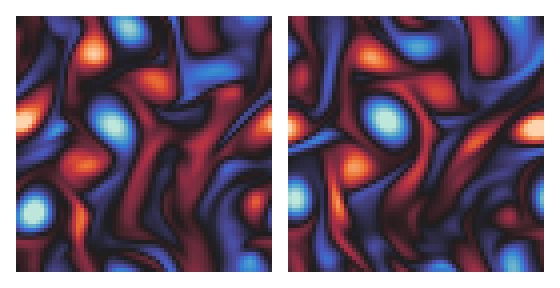

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    dtype = next(score.parameters()).dtype
except StopIteration:
    dtype = torch.float32

# ---- forward(x,t) を 3引数互換にしつつ、勾配を有効化して x を勾配対象にするアダプタ ----
class WithC(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x, t, c=None):
        # ★ inference_mode だと grad は再有効化できないので
        #   呼び出し側で inference_mode を使わないこと（下で対応）。
        # ★ x を勾配対象に昇格（leaf化）
        x = x.detach().requires_grad_(True)
        with torch.enable_grad():
            return self.base(x, t)

# ---- 既存構成そのまま ----
y_star_dev = y_star.to(device=device, dtype=dtype)
inner = VPSDE(score, shape=()).to(device)
eps = DPSGaussianScore(y_star_dev, A=A, zeta=1.0, sde=inner).to(device)

# 3引数互換 & 勾配対応に
eps3 = WithC(eps).to(device)
sde = VPSDE(eps3, shape=x_star.shape).to(device)

# ---- サンプリング：★ inference_mode を使わない（grad が必要だから）----
eps.eval(); inner.eval()
# with torch.inference_mode():  # ← 使わない
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()

# 可視化
w = chain.vorticity(x[::4])
draw(w, zoom=4).save('x_dps_assim.png')
draw(w, zoom=4)

In [31]:
(A(x) - y_star).std()

tensor(0.4974)

## Non-linear observation process

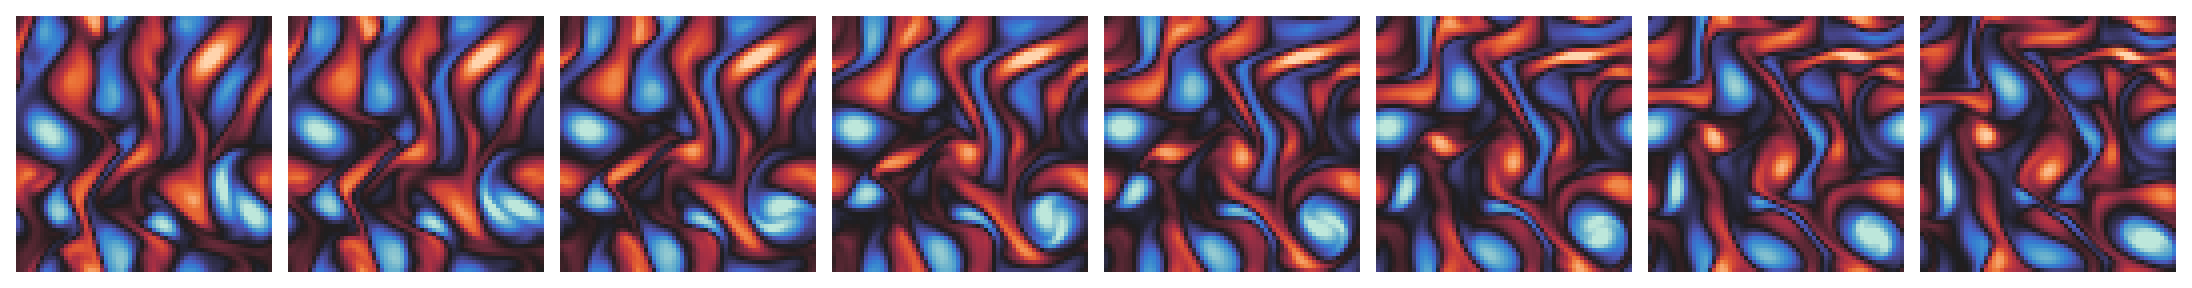

In [32]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][2, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_saturation.png')
draw(w, zoom=4)

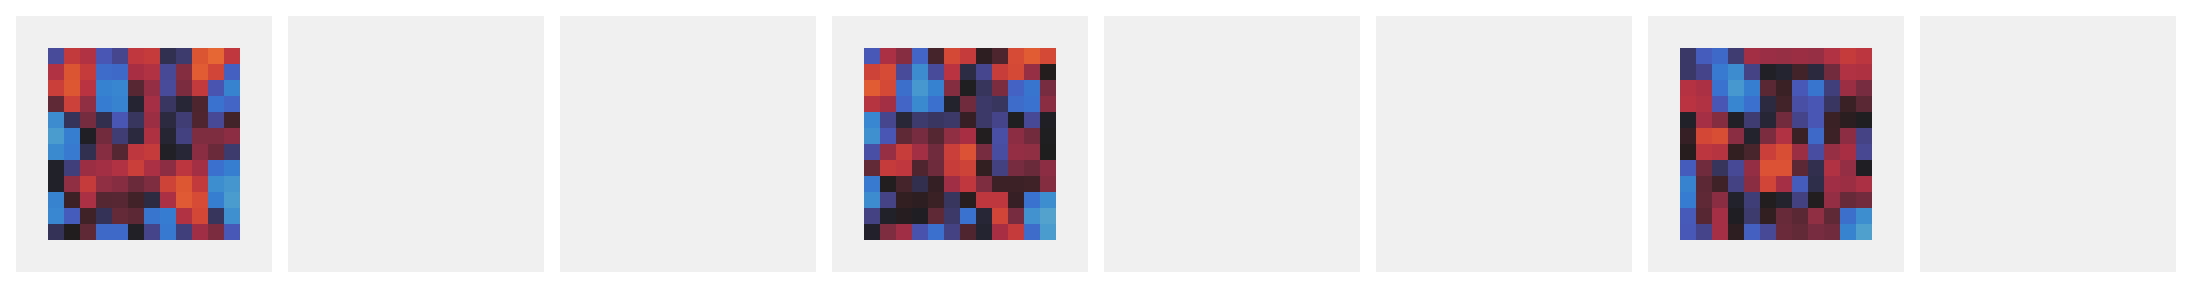

In [33]:
def A(x):
    x = chain.coarsen(x[..., ::3, :, :, :], 4)
    w = chain.vorticity(x)
    w = w / (1 + abs(w))

    return w[..., 2:14, 2:14]

y_star = torch.normal(A(x_star), 0.05)

w = chain.vorticity(chain.coarsen(x_star, 4))
w = w / (1 + abs(w))

mask = np.zeros((8, 16, 16), dtype=bool)
mask[::3, 2:14, 2:14] = True

draw(w, mask, pad=1, zoom=16).save('y_star_saturation.png')
draw(w, mask, pad=1, zoom=16)

  0%|                                                           | 0/512 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████| 512/512 [01:37<00:00,  5.26it/s]


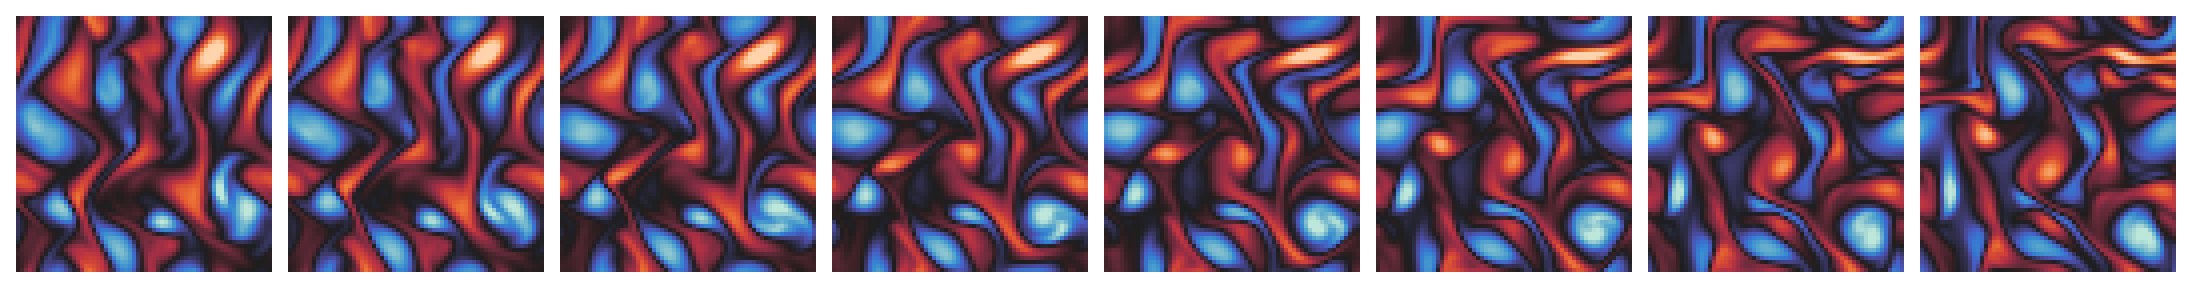

In [34]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.05,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_saturation.png')
draw(w, zoom=4)

In [35]:
(A(x) - y_star).std()

tensor(0.0595)

  0%|                                                           | 0/512 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████| 512/512 [01:37<00:00,  5.27it/s]


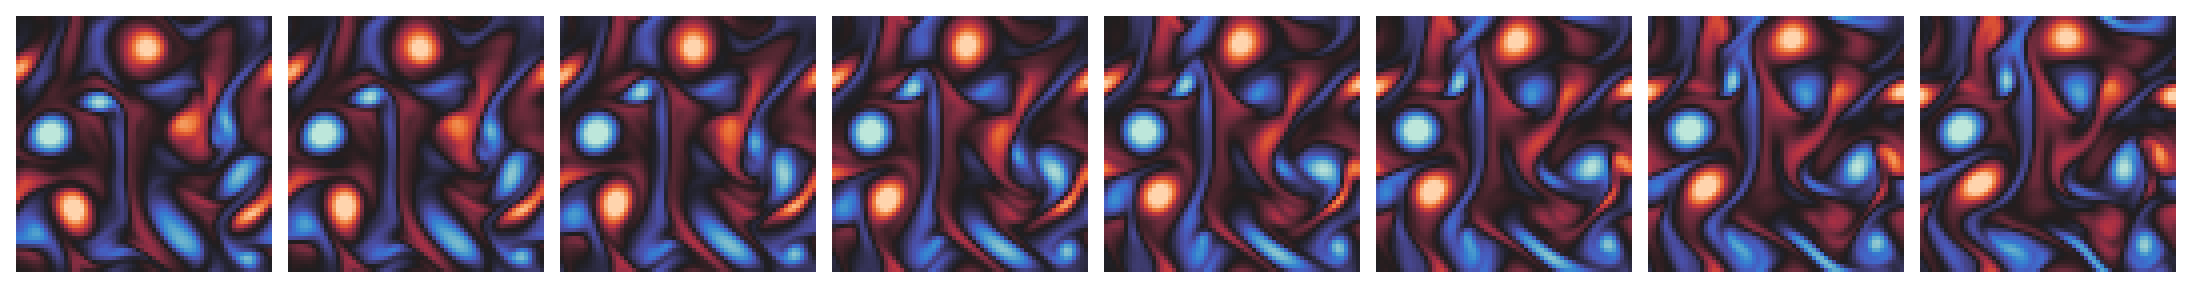

In [37]:
# sde = VPSDE(
#     DPSGaussianScore(
#         y_star,
#         A=A,
#         zeta=1.0,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=x_star.shape,
# ).cuda()

# x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()
# w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_saturation.png')
# draw(w, zoom=4)

# --- デバイス・dtype揃え ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    dtype = next(score.parameters()).dtype
except StopIteration:
    dtype = torch.float32

# --- forward(x,t) を forward(x,t,c=None) に適合させ、
#     かつ autograd が必要な x を勾配対象に昇格する薄いラッパ ---
class WithC(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x, t, c=None):
        x = x.detach().requires_grad_(True)  # ★ DPS で autograd.grad(err, x) を取るため
        with torch.enable_grad():            # ★ inference_mode の無効化（局所）
            return self.base(x, t)

# --- 既存構成そのまま（元コード無改変） ---
# 観測と内側SDEをデバイス/型に合わせる
y_star_dev = y_star.to(device=device, dtype=dtype)
inner = VPSDE(score, shape=()).to(device)

# DPSGaussianScore を作成してラップ
eps = DPSGaussianScore(y_star_dev, A=A, zeta=1.0, sde=inner).to(device)
eps3 = WithC(eps).to(device)

# 外側 SDE（.cuda() 固定ではなく .to(device)）
sde = VPSDE(eps3, shape=x_star.shape).to(device)

# --- サンプリング（※ inference_mode は使わない：DPS が勾配を使うため） ---
eps.eval(); inner.eval()
x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()

# --- 可視化 ---
w = chain.vorticity(x)
draw(w, zoom=4).save('x_dps_saturation.png')
draw(w, zoom=4)

In [38]:
(A(x) - y_star).std()

tensor(0.5257)

## Subsampling

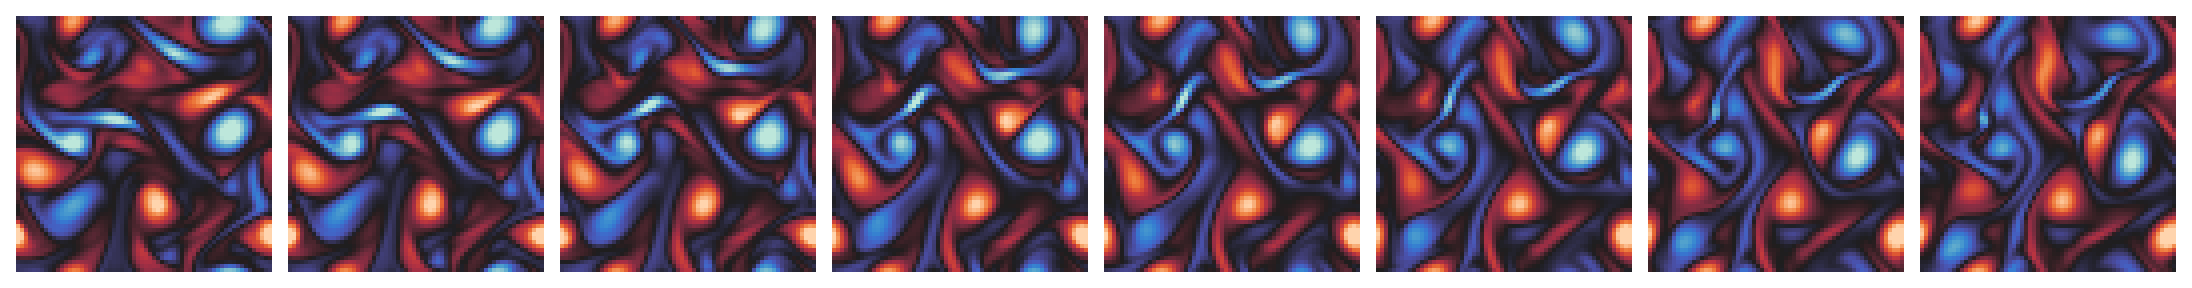

In [39]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][3, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_sub.png')
draw(w, zoom=4)

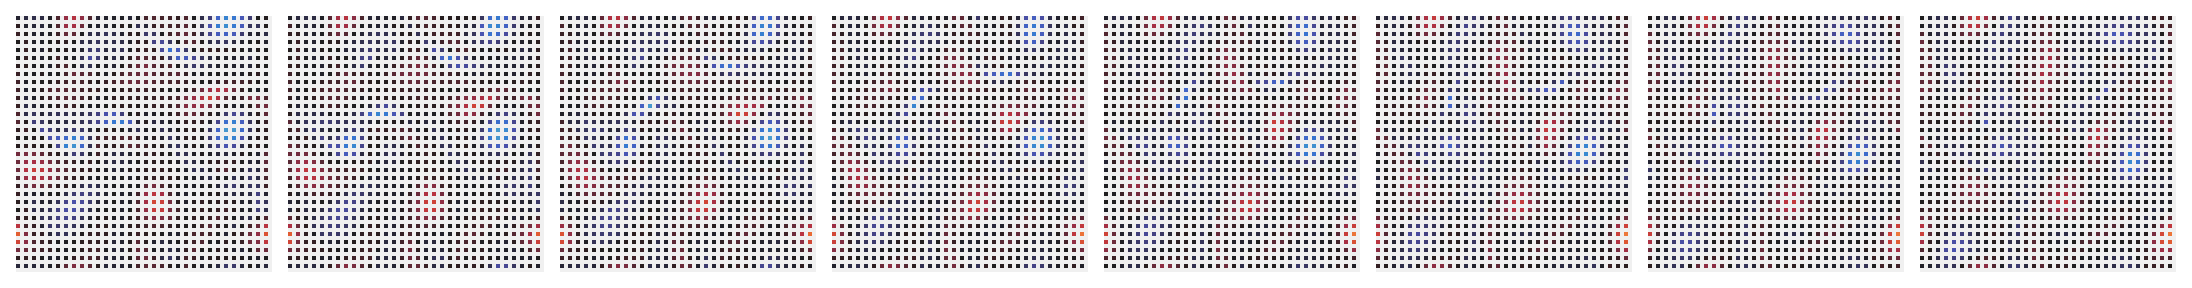

In [40]:
def A(x):
    return x[..., ::2, ::2]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::2, ::2] = True

draw(w, mask, zoom=4).save('y_star_sub_2.png')
draw(w, mask, zoom=4)

  2%|▉                                                  | 5/256 [00:00<00:46,  5.35it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.29it/s]


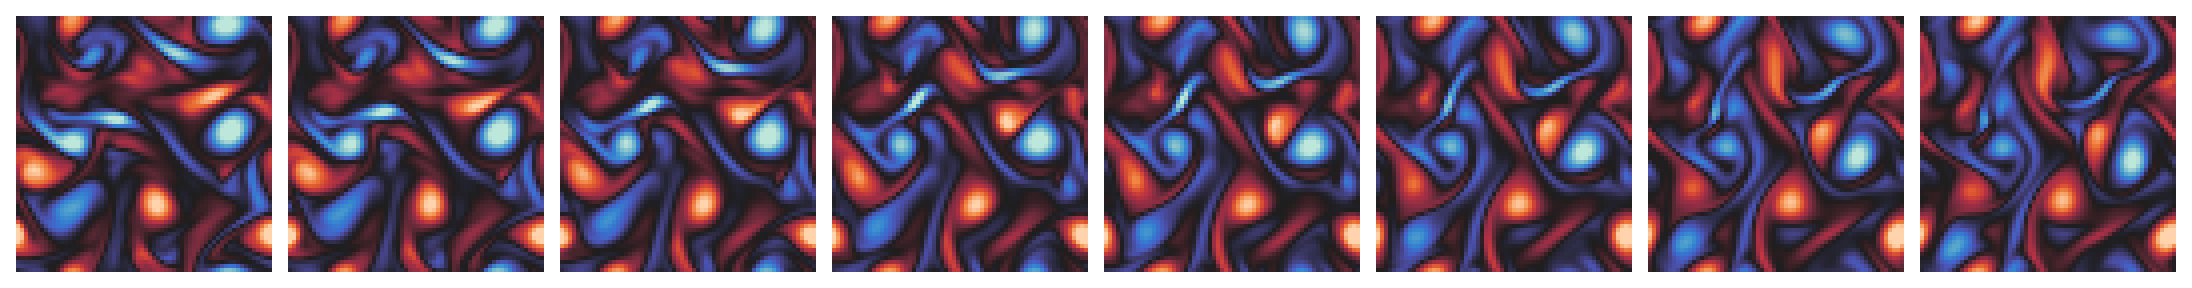

In [41]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_2.png')
draw(w, zoom=4)

  0%|▏                                                  | 1/256 [00:00<00:40,  6.27it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.29it/s]


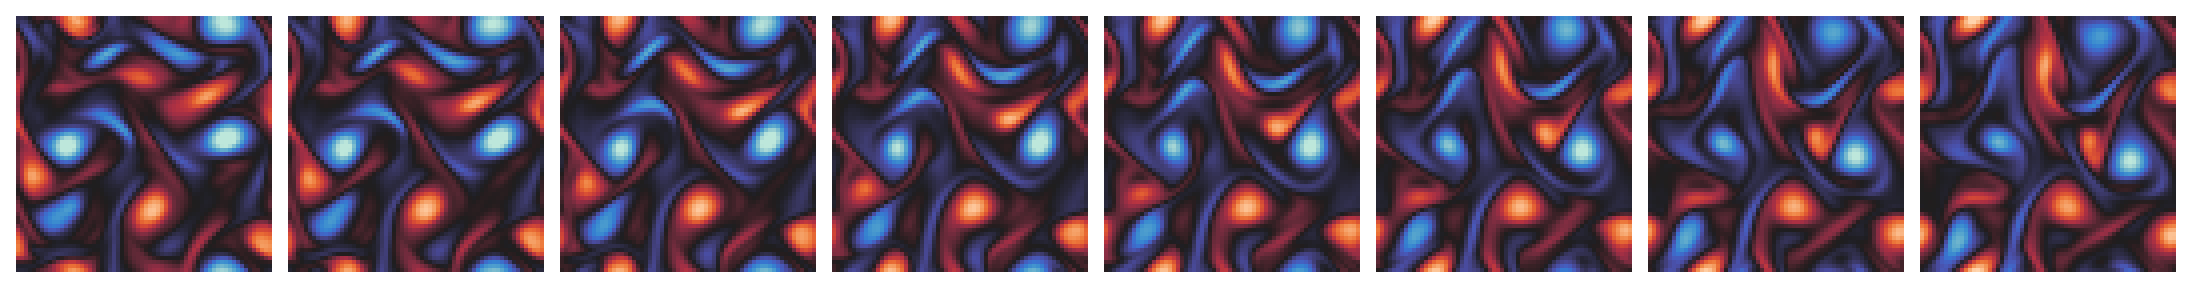

In [42]:
# sde = VPSDE(
#     DPSGaussianScore(
#         y_star,
#         A=A,
#         zeta=1.0,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=x_star.shape,
# ).cuda()

# x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
# w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_sub_2.png')
# draw(w, zoom=4)


# --- デバイス・dtype 揃え ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    dtype = next(score.parameters()).dtype
except StopIteration:
    dtype = torch.float32

# --- forward(x,t) を forward(x,t,c=None) に適合、
#     かつ DPS 内の autograd 用に x を勾配対象へ昇格 ---
class WithC(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x, t, c=None):
        x = x.detach().requires_grad_(True)
        with torch.enable_grad():
            return self.base(x, t)

# 観測と内側 SDE を準備
y_star_dev = y_star.to(device=device, dtype=dtype)
inner = VPSDE(score, shape=()).to(device)

# DPS をラップして 3 引数互換＋勾配対応に
eps = DPSGaussianScore(y_star_dev, A=A, zeta=1.0, sde=inner).to(device)
eps3 = WithC(eps).to(device)

# 外側 SDE（.cuda() 固定は避けて .to(device)）
sde = VPSDE(eps3, shape=x_star.shape).to(device)

# サンプリング（※ inference_mode は使わない）
eps.eval(); inner.eval()
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()

# 可視化
w = chain.vorticity(x)
draw(w, zoom=4).save('x_dps_sub_2.png')
draw(w, zoom=4)

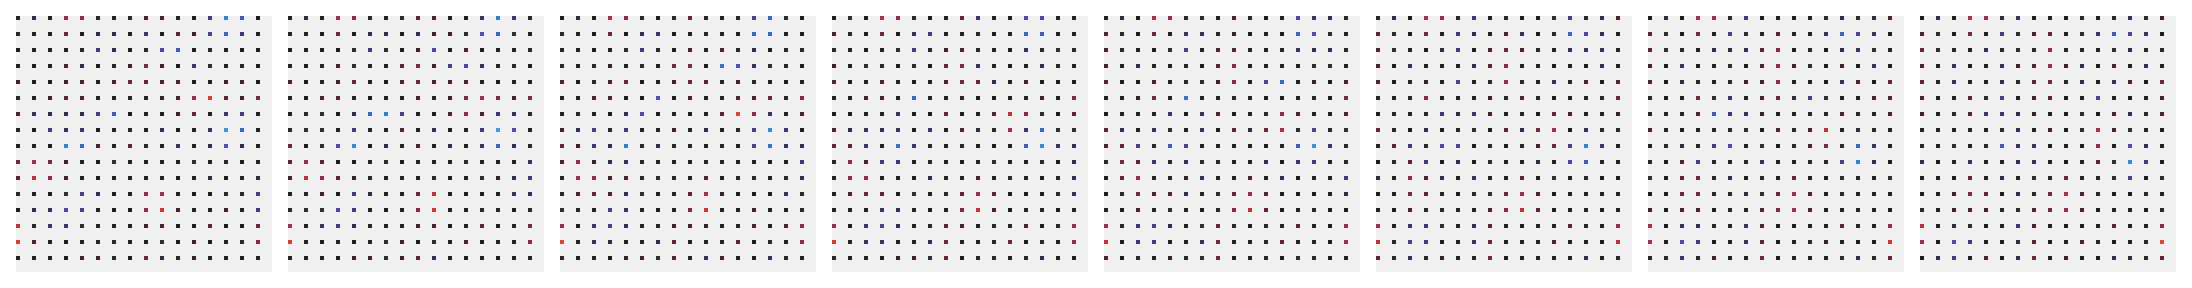

In [43]:
def A(x):
    return x[..., ::4, ::4]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::4, ::4] = True

draw(w, mask, zoom=4).save('y_star_sub_4.png')
draw(w, mask, zoom=4)

  1%|▍                                                  | 2/256 [00:00<00:45,  5.58it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.29it/s]


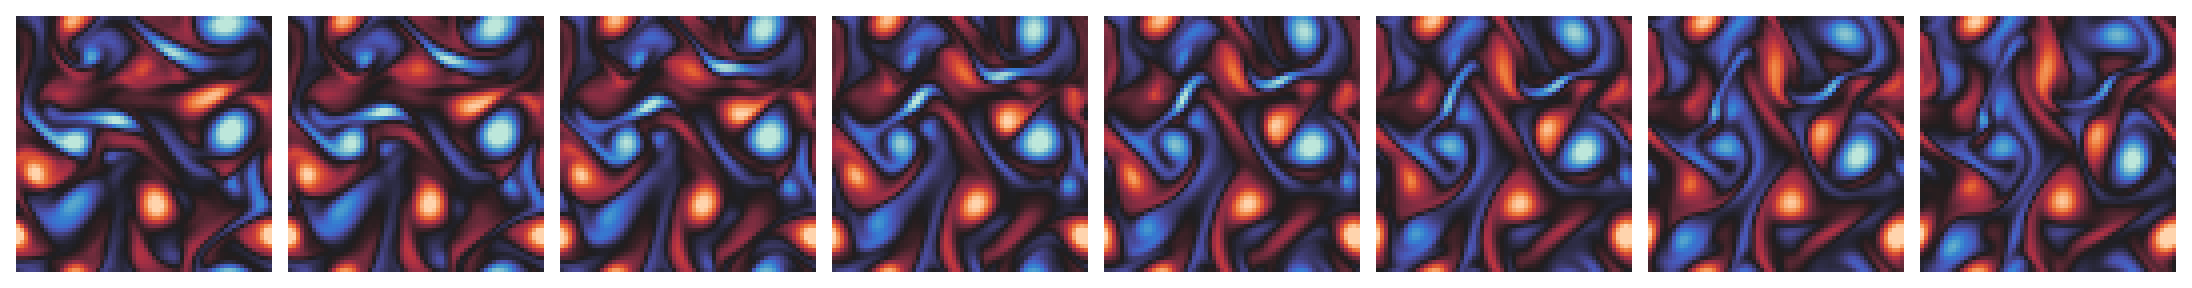

In [44]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_4.png')
draw(w, zoom=4)

  1%|▍                                                  | 2/256 [00:00<00:45,  5.59it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.29it/s]


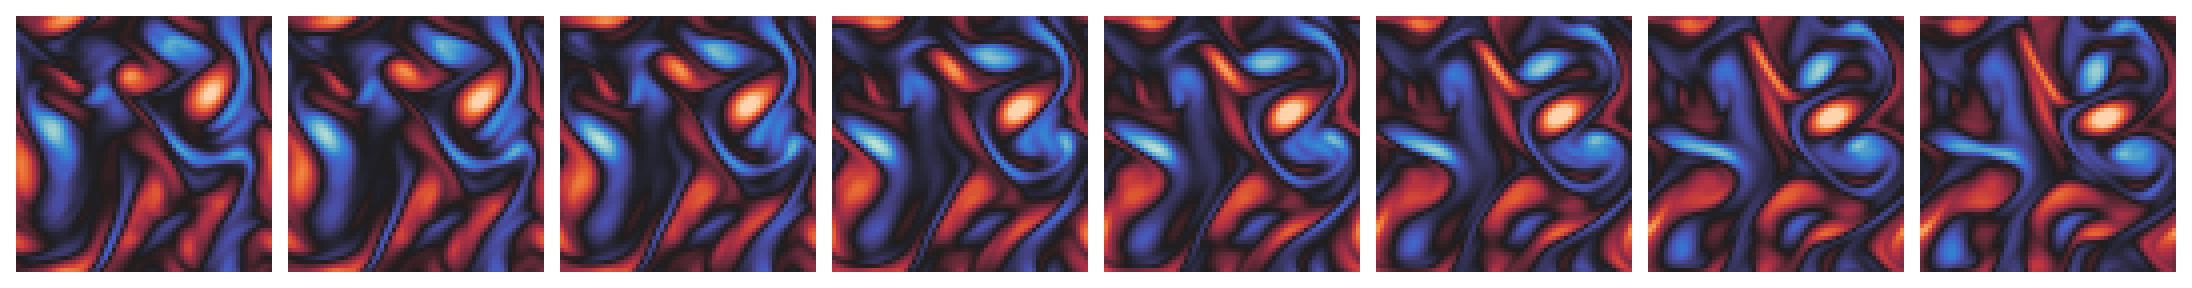

In [45]:
# sde = VPSDE(
#     DPSGaussianScore(
#         y_star,
#         A=A,
#         zeta=1.0,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=x_star.shape,
# ).cuda()

# x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
# w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_sub_4.png')
# draw(w, zoom=4)

# --- device / dtype ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    dtype = next(score.parameters()).dtype
except StopIteration:
    dtype = torch.float32

# --- adapter: accept (x, t, c) and enable autograd for x ---
class WithC(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x, t, c=None):
        x = x.detach().requires_grad_(True)  # DPS needs grad wrt x
        with torch.enable_grad():            # don't use inference_mode here
            return self.base(x, t)

# --- build DPS score and wrap it ---
y_star_dev = y_star.to(device=device, dtype=dtype)
inner = VPSDE(score, shape=()).to(device)

eps = DPSGaussianScore(y_star_dev, A=A, zeta=1.0, sde=inner).to(device)
eps3 = WithC(eps).to(device)

# --- outer SDE (avoid .cuda() fixed call) ---
sde = VPSDE(eps3, shape=x_star.shape).to(device)

# --- sample (no inference_mode; DPS uses autograd) ---
eps.eval(); inner.eval()
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()

# --- visualize ---
w = chain.vorticity(x)
draw(w, zoom=4).save('x_dps_sub_4.png')
draw(w, zoom=4)

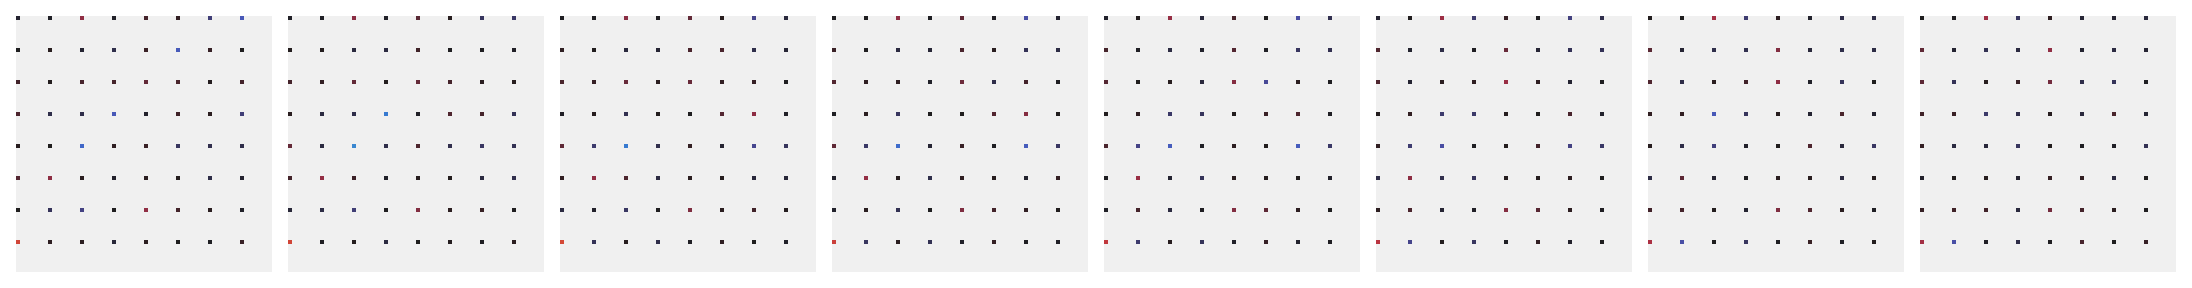

In [46]:
def A(x):
    return x[..., ::8, ::8]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::8, ::8] = True

draw(w, mask, zoom=4).save('y_star_sub_8.png')
draw(w, mask, zoom=4)

  0%|▏                                                  | 1/256 [00:00<00:40,  6.23it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.29it/s]


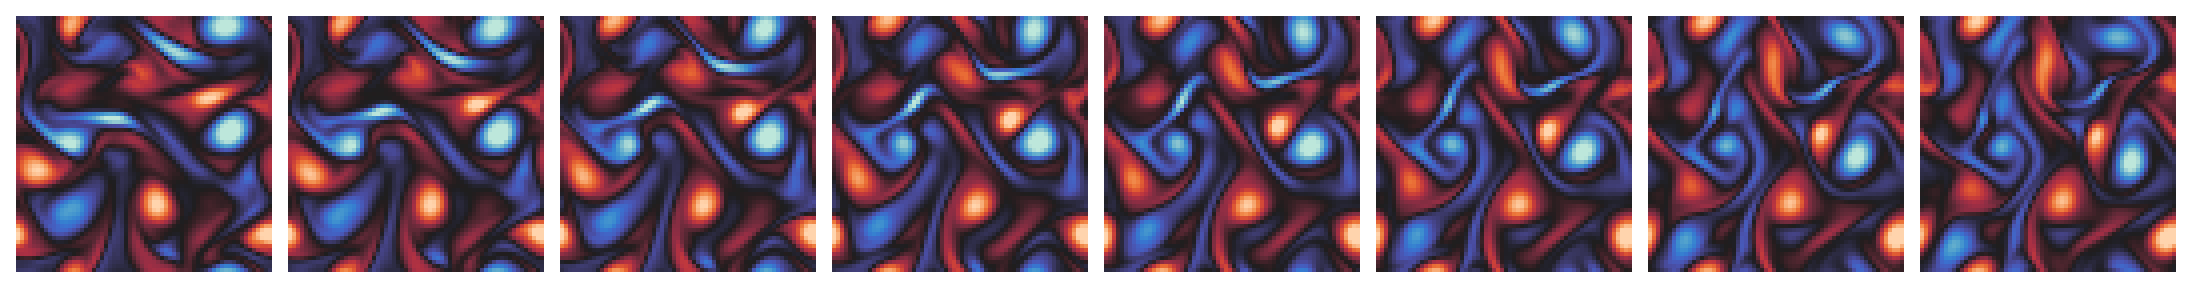

In [47]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_8.png')
draw(w, zoom=4)

  0%|▏                                                  | 1/256 [00:00<00:41,  6.10it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.29it/s]


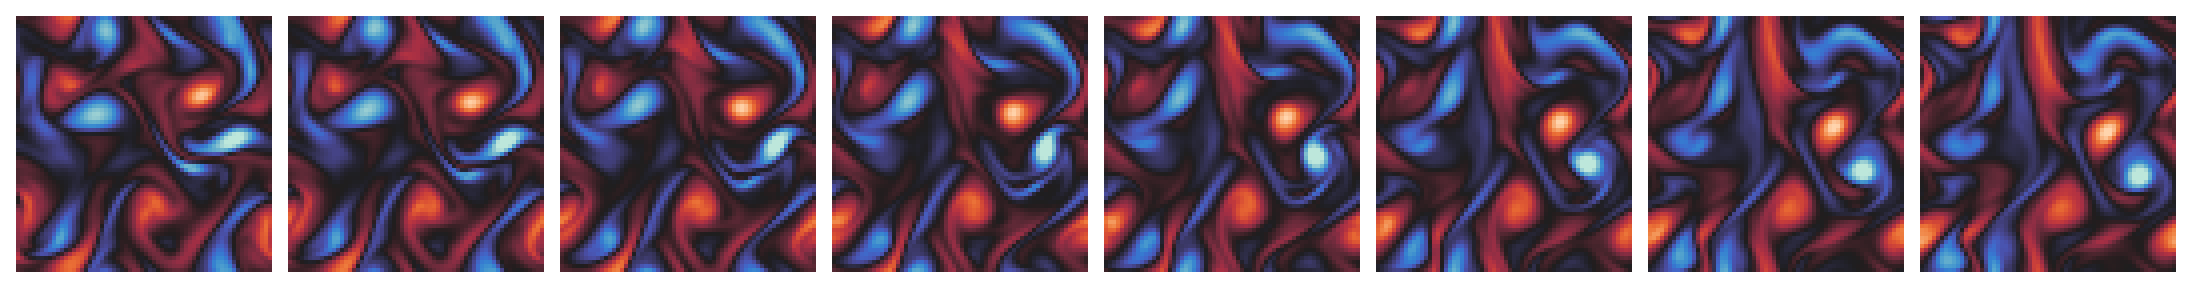

In [48]:
# sde = VPSDE(
#     DPSGaussianScore(
#         y_star,
#         A=A,
#         zeta=1.0,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=x_star.shape,
# ).cuda()

# x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
# w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_sub_8.png')
# draw(w, zoom=4)


# --- device / dtype ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    dtype = next(score.parameters()).dtype
except StopIteration:
    dtype = torch.float32

# --- adapter: accept (x, t, c) and enable autograd for x ---
class WithC(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x, t, c=None):
        x = x.detach().requires_grad_(True)  # DPS needs grad wrt x
        with torch.enable_grad():            # don't use inference_mode here
            return self.base(x, t)

# --- build DPS score and wrap it ---
y_star_dev = y_star.to(device=device, dtype=dtype)
inner = VPSDE(score, shape=()).to(device)

eps = DPSGaussianScore(y_star_dev, A=A, zeta=1.0, sde=inner).to(device)
eps3 = WithC(eps).to(device)

# --- outer SDE ---
sde = VPSDE(eps3, shape=x_star.shape).to(device)

# --- sample (no inference_mode; DPS uses autograd) ---
eps.eval(); inner.eval()
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()

# --- visualize ---
w = chain.vorticity(x)
draw(w, zoom=4).save('x_dps_sub_8.png')
draw(w, zoom=4)

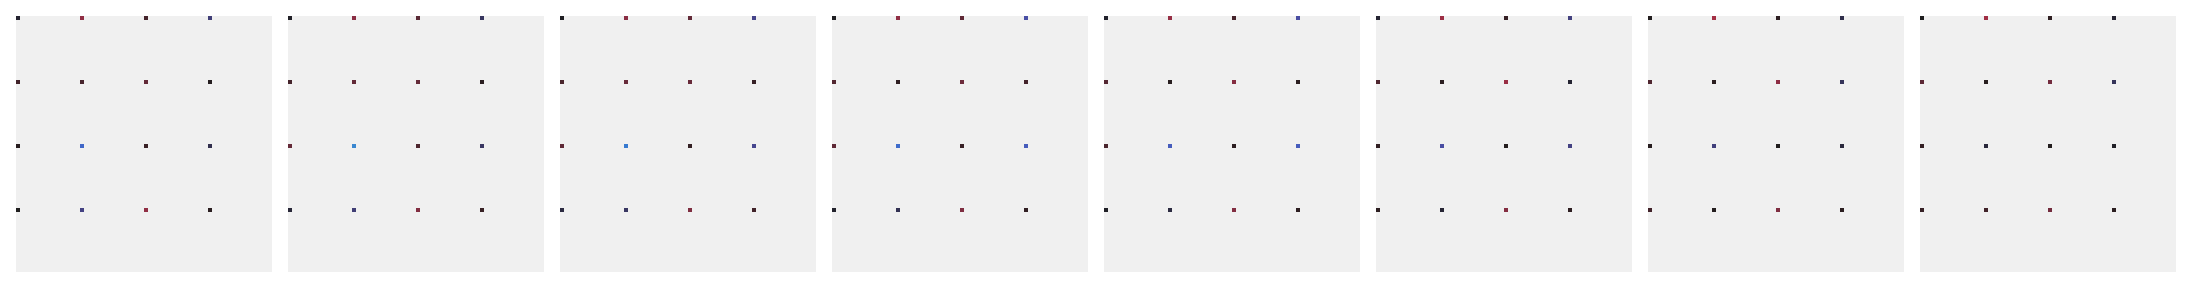

In [49]:
def A(x):
    return x[..., ::16, ::16]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::16, ::16] = True

draw(w, mask, zoom=4).save('y_star_sub_16.png')
draw(w, mask, zoom=4)

  0%|▏                                                  | 1/256 [00:00<00:41,  6.14it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.30it/s]


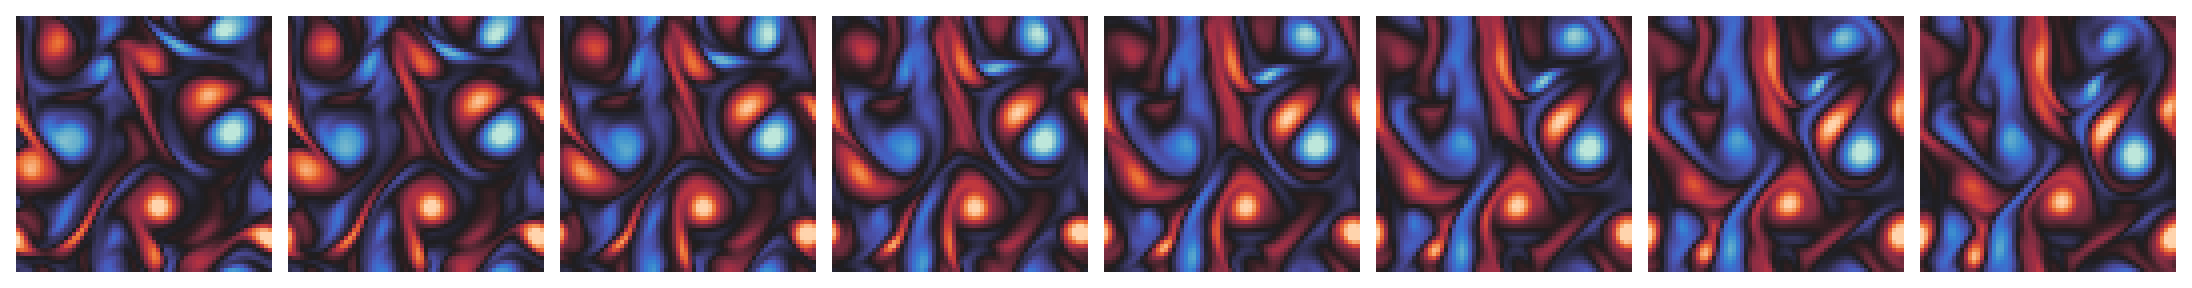

In [50]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_16.png')
draw(w, zoom=4)

  0%|▏                                                  | 1/256 [00:00<00:40,  6.27it/s]

100%|█████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.30it/s]


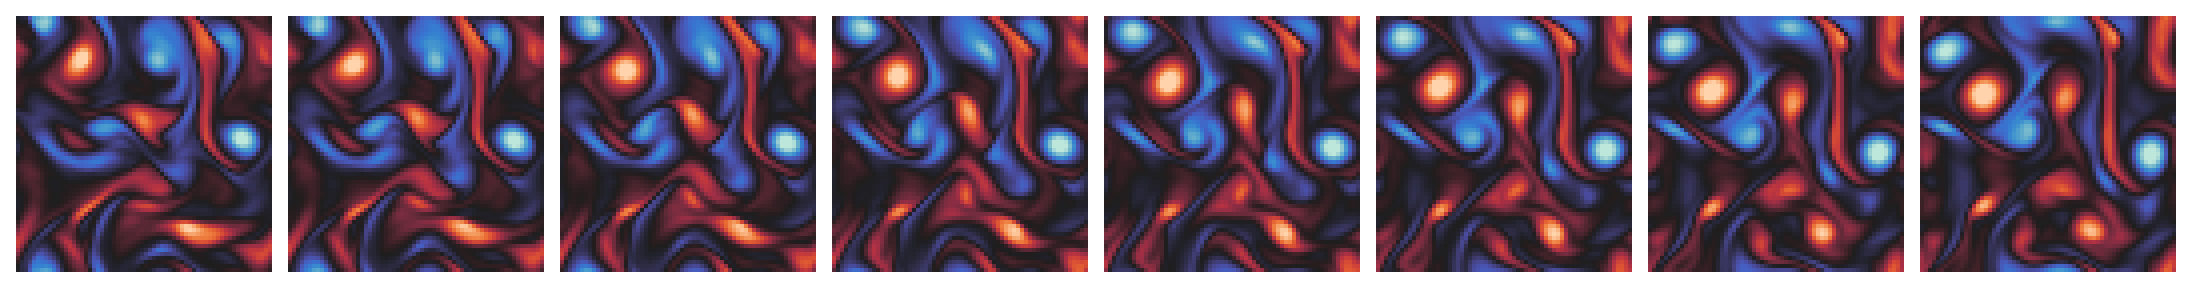

In [51]:
# sde = VPSDE(
#     DPSGaussianScore(
#         y_star,
#         A=A,
#         zeta=1.0,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=x_star.shape,
# ).cuda()

# x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
# w = chain.vorticity(x)

# draw(w, zoom=4).save('x_dps_sub_16.png')
# draw(w, zoom=4)


# --- device / dtype ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    dtype = next(score.parameters()).dtype
except StopIteration:
    dtype = torch.float32

# --- adapter: accept (x, t, c) and keep autograd for DPS ---
class WithC(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x, t, c=None):
        x = x.detach().requires_grad_(True)  # DPS needs grad wrt x
        with torch.enable_grad():            # don't use inference_mode here
            return self.base(x, t)

# --- build DPS score and wrap it ---
y_star_dev = y_star.to(device=device, dtype=dtype)
inner = VPSDE(score, shape=()).to(device)
eps = DPSGaussianScore(y_star_dev, A=A, zeta=1.0, sde=inner).to(device)
eps3 = WithC(eps).to(device)

# --- outer SDE ---
sde = VPSDE(eps3, shape=x_star.shape).to(device)

# --- sample (no inference_mode; DPS uses autograd) ---
eps.eval(); inner.eval()
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()

# --- visualize ---
w = chain.vorticity(x)
draw(w, zoom=4).save('x_dps_sub_16.png')
draw(w, zoom=4)


## Loop

  1%|▍                                                  | 2/256 [00:04<09:23,  2.22s/it]

100%|█████████████████████████████████████████████████| 256/256 [10:13<00:00,  2.39s/it]


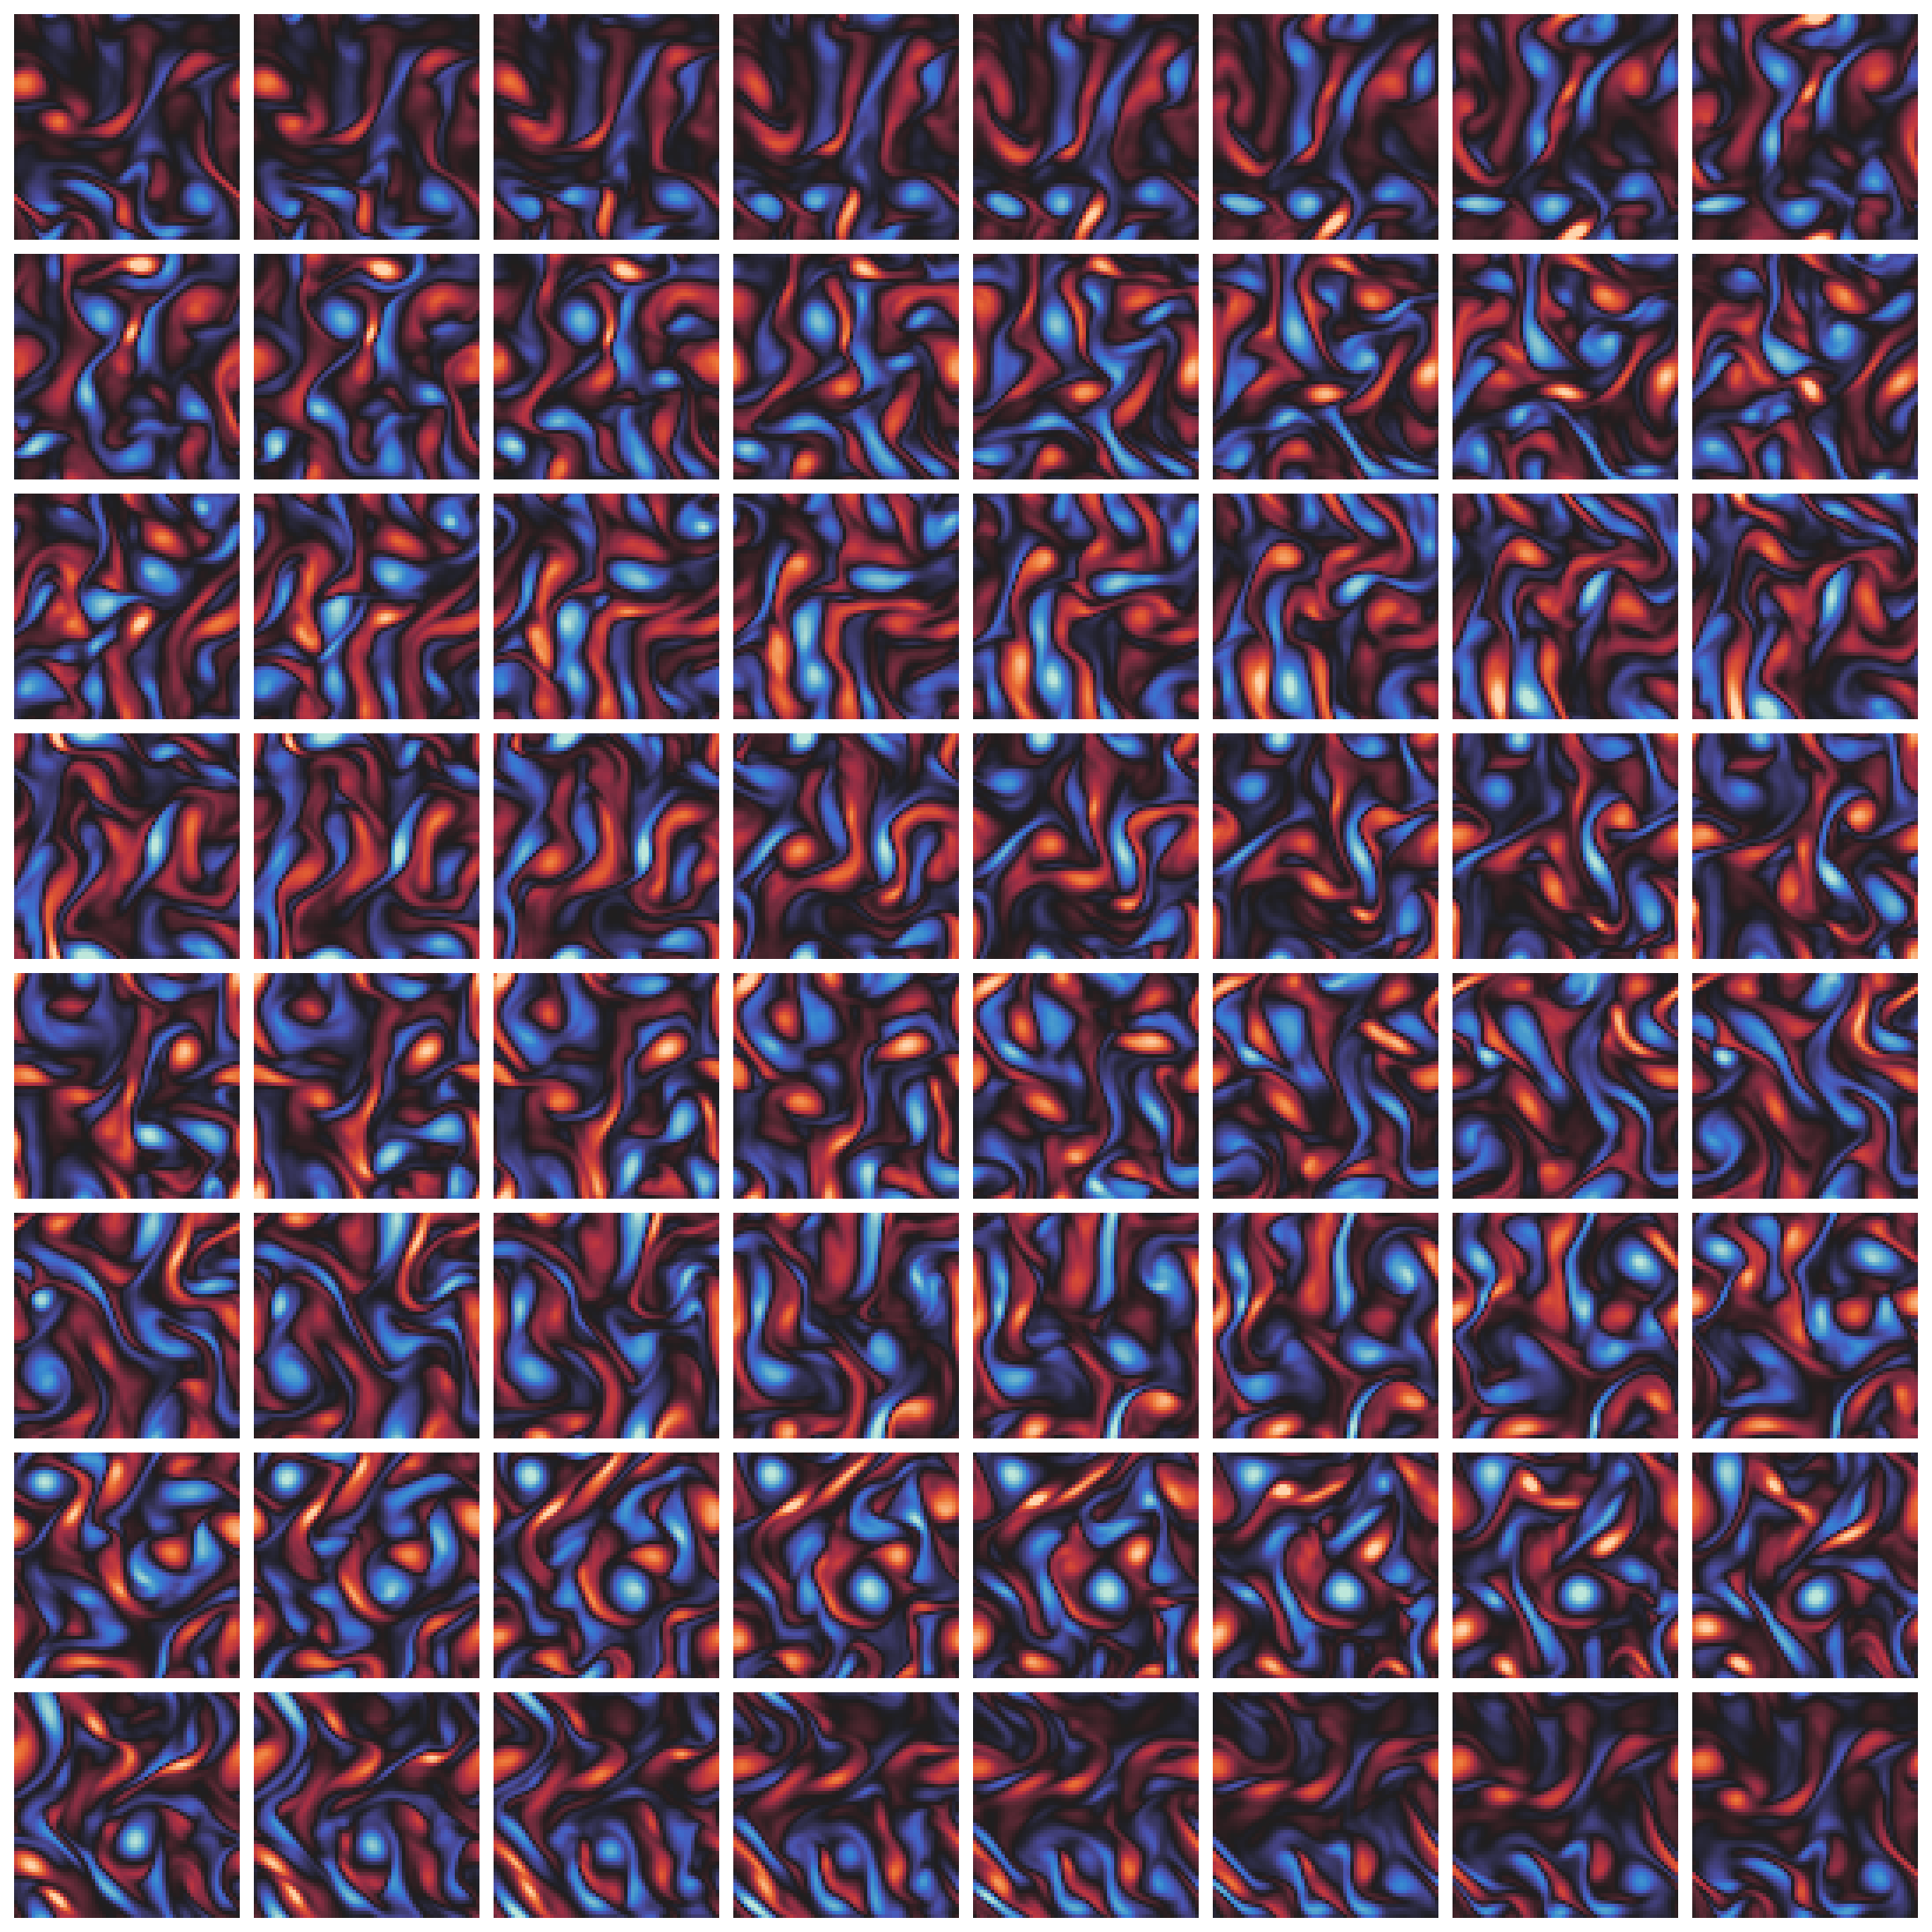

In [58]:
# sde = VPSDE(
#     GaussianScore(
#         torch.zeros(2, 64, 64),
#         A=lambda x: x[:, 0] - x[:, -1],
#         std=0.01,
#         sde=VPSDE(score, shape=()),
#         gamma=0.1,
#     ),
#     shape=(127, 2, 64, 64),
# ).cuda()

# x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
# w = chain.vorticity(x[::2])

# draw(w.reshape(8, 8, 64, 64), zoom=4).save('x_loop.png')
# draw(w.reshape(8, 8, 64, 64), zoom=4)

import os, inspect

# ==== GPU選択：GPU1が空いているので優先 ====
use_cuda = torch.cuda.is_available()
gpu_index = 1 if (use_cuda and torch.cuda.device_count() > 1) else (0 if use_cuda else None)
device = torch.device(f"cuda:{gpu_index}") if gpu_index is not None else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(device.index)

# --- A(x) は (batch, 64, 64) を返す想定（例：2chの差分） ---
A = lambda x: x[:, 0] - x[:, -1]  # x: (B, 2, 64, 64) -> (B, 64, 64)

# y は A(x) とブロードキャスト整合にする（(64,64) なら batch に自動拡張）
y0 = torch.zeros(64, 64, device=device, dtype=dtype)

# --- adapter: forward(x,t,c) 受けに統一し、必要なら autograd も有効化 ---
class WithC(nn.Module):
    def __init__(self, base: nn.Module, need_grad: bool = True):
        super().__init__()
        self.base = base
        self.need_grad = need_grad
    def forward(self, x, t, c=None):
        # GaussianScore 実装が autograd.grad を使う版でも通るように保険を掛ける
        if self.need_grad:
            x = x.detach().requires_grad_(True)
            with torch.enable_grad():
                return self.base(x, t)
        else:
            return self.base(x, t)

# --- 内側SDE & GaussianScore 本体 ---
inner = VPSDE(score, shape=()).to(device)
eps_raw = GaussianScore(
    y=y0,
    A=A,
    std=0.01,
    sde=inner,
    gamma=0.1,
).to(device)

# ★ 3引数互換 & 勾配対応にラップ（GaussianScore が2引数実装でもOK）
eps = WithC(eps_raw, need_grad=True).to(device)

# --- 外側 SDE（.cuda() 固定は避けて .to(device)） ---
sde = VPSDE(eps, shape=(127, 2, 64, 64)).to(device)

# --- サンプリング（※ inference_mode は使わない：実装が勾配を使う可能性があるため） ---
eps.eval(); inner.eval()
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()

# --- 可視化 ---
w = chain.vorticity(x[::2])                 # 127 -> 64 枚に間引き
grid = w.reshape(8, 8, 64, 64)              # 8x8 タイル
draw(grid, zoom=4).save('x_loop.png')
draw(grid, zoom=4)
